In [23]:
import init

from analisys.bkt_analisys import *
from analisys.data_analisys import *
from analisys.graph_analisys import *
from analisys.optmizer_analisys import *


import pandas as pd
import seaborn as sns
sns.set_theme()

import random
import os

from backend.resampler import *
from backend.mt5_tools import *

from statsmodels.tsa.stattools import adfuller
from analisys.graph_analisys import moving_avg
from secrets import token_hex as token


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.orca.config.use_xvfb = True


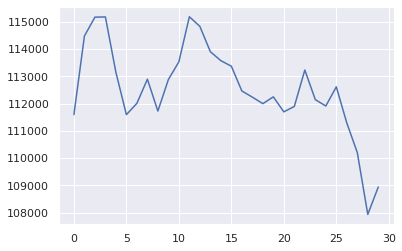

In [24]:
#definindo parametros

start_date = '2022.01.21'
end_date = '2022.03.07'


param = 'roiloss'
csv_l = 'symbols_ibovf.csv'
opt = 'forest'


timeframe = 5 # timeframe = 5 minutos
sample_size = 10 # quantidade de pares sendo negociados simultaneamente
n_opt = 25 # parametro do optmizer
lags = 22 # parametro do 'teste de cointegracao'
p_size = 10000 # tamanho da posicao

d_train = 30 # numero de dias sendo 'treinados'.
d_test = 5 # numero de dias sendo 'testados'.


ibov = pd.DataFrame(mt5_singlehistoricaldata('IBOV', 16408, start_date, end_date, forex=False, SERVER='tcp://192.168.100.106:10000')).iloc[::-1]

period = [10,100]
stop_n = [25,50]
stop_r = [-300, 0]
s_spread = [0, 5]
l_spread = [-5, 0]
tp_s =[-1, 0]
tp_l =[0, 1]
tp_r =[700, 3000] #700,3000
c_min=[50, 250]


plt.plot(ibov['close'])

space_param = [(period[0], period[1]),
                (s_spread[0], s_spread[1]),
                (l_spread[0], l_spread[1]),
                (tp_s[0], tp_s[1]),
                (tp_l[0], tp_l[1]),
                (tp_r[0], tp_r[1]),
                (stop_n[0], stop_n[1]),
                (stop_r[0], stop_r[1]),
                (c_min[0], c_min[1])]



In [25]:
def get_days(start_date, end_date, d_train, d_test):

    ibov = mt5_singlehistoricaldata('IBOV', 16408, start_date, end_date, SERVER='tcp://192.168.100.106:10000')
    ibov_date = list(ibov['date'])
    ibov_date.reverse()

    date_iteration = []

    for d in range(len(ibov_date))[:-(d_train+d_test)]:

        train_startdate = ibov_date[d].split(' ')[0]
        train_enddate = ibov_date[d+d_train].split(' ')[0]
        test_startdate = ibov_date[d+d_train].split(' ')[0]
        test_enddate = ibov_date[d+d_test+d_train].split(' ')[0]

        date_iteration.append(tuple([train_startdate, train_enddate,
                                    test_startdate, test_enddate]))

    #real_startdate = date_iteration[0][2]
    #real_enddate = date_iteration[-1][-2]

    return date_iteration, ibov_date

def cointpair_selection(hist, dataframe, lags):

    co = h_coint(hist, dataframe, n_lags=lags)
    co = pd.DataFrame(co)
    co = co.sort_values(by=['pvalue'])
    co = co.reset_index(drop=True)

    new_co = pd.DataFrame({'pvalue':pd.Series([]), 'stdx':pd.Series([]), 
                                'stdy':pd.Series([]), 'x':pd.Series([]), 'y':pd.Series([])})


    if(len(co) == 0):
        return new_co

    co_len = [i for i in range(len(co))]

    for j in co_len:

        x,y = list(co['x'])[j], list(co['y'])[j]
        
        new_co = new_co.append(co.iloc()[j])
        new_co = new_co.reset_index(drop=True)
    
    new_co = new_co.reset_index(drop=True)



    return new_co

In [26]:
d = get_days(start_date, end_date, d_train, d_test)
len(d[1])
print(len(d[1]), d[1])
print(d[1][2])

30 ['2022.01.21 00:00', '2022.01.24 00:00', '2022.01.25 00:00', '2022.01.26 00:00', '2022.01.27 00:00', '2022.01.28 00:00', '2022.01.31 00:00', '2022.02.01 00:00', '2022.02.02 00:00', '2022.02.03 00:00', '2022.02.04 00:00', '2022.02.07 00:00', '2022.02.08 00:00', '2022.02.09 00:00', '2022.02.10 00:00', '2022.02.11 00:00', '2022.02.14 00:00', '2022.02.15 00:00', '2022.02.16 00:00', '2022.02.17 00:00', '2022.02.18 00:00', '2022.02.21 00:00', '2022.02.22 00:00', '2022.02.23 00:00', '2022.02.24 00:00', '2022.02.25 00:00', '2022.03.02 00:00', '2022.03.03 00:00', '2022.03.04 00:00', '2022.03.07 00:00']
2022.01.25 00:00


In [27]:
hist = mt5_historicaldata(timeframe, start_date, end_date, csv_list = csv_l, interpol=False, bolsa='IBOV', SERVER='tcp://192.168.100.106:10000')



In [28]:
co_hist = cointpair_selection(hist, timeframe, lags)
co_hist

['B3SA3', 'BBAS3', 'BBDC3', 'BBDC4', 'BBSE3', 'BPAC11', 'BRML3', 'CIEL3', 'CYRE3', 'IRBR3', 'ITSA4', 'ITUB4', 'MULT3', 'SANB11', 'SULA11']


,pvalue,stdx,stdy,x,y
0,9.071359e-12,2.192367,2.749751,BBDC3,BBDC4
1,2.635269e-08,2.749751,2.192367,BBDC4,BBDC3
2,1.281163e-05,1.177791,1.225692,BRML3,ITSA4
3,1.764049e-05,1.225692,1.177791,ITSA4,BRML3
4,1.463379e-04,2.701488,3.064095,MULT3,BBSE3
5,3.552278e-04,3.195516,3.064095,ITUB4,BBSE3
6,1.169727e-03,2.701488,3.291059,MULT3,BPAC11
7,3.236187e-03,3.064095,3.195516,BBSE3,ITUB4
8,4.278314e-03,3.064095,2.701488,BBSE3,MULT3
9,7.017670e-03,3.291059,2.701488,BPAC11,MULT3


In [29]:
sample_x = co_hist['x'], 
sample_y = co_hist['y']

sample = sample_x, sample_y

In [30]:
name_x = 'MULT3'
name_y = 'BPAC11'
df_treino = hist
pos_size = 10000
opt_param = param

hist[name_x].replace(0, np.NaN, inplace=True)
hist[name_y].replace(0, np.NaN, inplace=True)

hist[name_x] = hist[name_x].interpolate(method='linear', limit_direction='forward', axis=0)
hist[name_y] = hist[name_y].interpolate(method='linear', limit_direction='forward', axis=0)


In [31]:

def simplebkt(symbol_x,
                symbol_y,
                name_x,
                name_y,
                _period,
                s_spread,
                l_spread,
                tp_s,
                tp_l,
                tp_r,
                stop_n,
                stop_r,
                cmin,
                optimizer=opt_param):

    #fname = '{}x{}x{}{}{}.json'.format(name_x, name_y, datetime.datetime.now().hour, datetime.datetime.now().minute, datetime.datetime.now().second)

    dic = runbkt_old(symbol_x, symbol_y, name_x, name_y, _period,s_spread, l_spread, tp_s, tp_l, stop_n ,cmin, pos_size)


    if(optimizer == 'profit'):
        return dic['profit']
    elif(optimizer == 'ppp'):
        return dic['profit_per_position']
    elif(optimizer == 'sr'):
        return dic['sucess_ratio']
    elif(optimizer == 'pl'):
        return dic['average_profit_loss']
    elif(optimizer == 'roi'):
        return dic['roi']*abs(dic['profit'])
    elif(optimizer == 'roiloss'):
        return -(0.02 - dic['roi'])
    elif(optimizer == 'dic'):
        return dic

    return dic 
    

def treino(args):

    _p, shortspread, longspread, takeprofitshort, takeprofitlong, takeprofitreturn, stopnumber, stopreturn, cmin = args
    r = simplebkt(df_treino[name_x], df_treino[name_y], name_x, name_y, _p, shortspread, longspread, takeprofitshort, takeprofitlong, takeprofitreturn, stopnumber, stopreturn,cmin, optimizer='roiloss')
    return -r



forest = forest_minimize(treino, space_param, random_state=0, verbose=0, n_calls = n_opt)

print(forest['x'])

[56, 2, -2, -1, 0, 2289, 37, -179, 220]


In [32]:
n =7
def results(forest, n):
    columns_value = ['period', 's_spread', 'l_spread', 'tp_short', 'tp_long','tp_return', 'n', 'stop', 'count']

    x_iters = np.array(forest['x_iters'])

    df = pd.DataFrame(data = x_iters, columns=columns_value)
    
    df['opt'] = -forest['func_vals']
    df = df.sort_values(['opt'], ascending=False)
    df_np = np.array(df.drop(columns=['opt']))
    df = df.reset_index().drop(columns='index')
    

    return df[:n], df_np[:n]

a, b = results(forest, n)
a

,period,s_spread,l_spread,tp_short,tp_long,tp_return,n,stop,count,opt
0,56,2,-2,-1,0,2289,37,-179,220,0.132324
1,36,2,0,-1,0,2401,42,-264,229,0.124122
2,52,2,0,-1,0,2391,37,-256,230,0.123912
3,41,2,0,-1,0,2964,44,-277,243,0.116103
4,63,2,0,-1,0,2498,35,-176,240,0.104792
5,65,3,0,-1,0,2365,32,-177,226,0.092245
6,94,3,-1,-1,0,1771,45,-169,150,0.051269


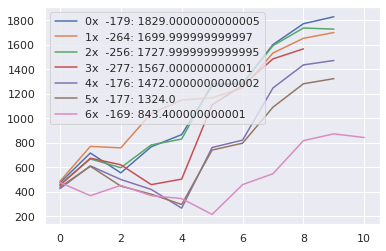

fourteenbis_live ('MULT3', 'BPAC11', 10000, 56, 2, -2, -1, 0, 2289, 37, -179, 220)


In [33]:
count = 0
for param in b:
    
    treino = simplebkt(df_treino[name_x], df_treino[name_y], name_x, name_y, param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], param[8], optimizer='dic')
    plt.plot(np.cumsum(treino['returns']), label=str('{}x  {}: {}'.format(str(count), a['stop'][count],sum(treino['returns']))))

    count+= 1

plt.legend()
plt.show()


num = 0
param_list = []
param_list.append(name_x)
param_list.append(name_y)
param_list.append(pos_size)


for i in b[num]:
    param_list.append(i)

print('fourteenbis_live',tuple(param_list))
